In [261]:
import numpy as np
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import statsmodels.stats.api as sms
from statsmodels.graphics.api import abline_plot
from statsmodels.sandbox.regression.predstd import wls_prediction_std

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

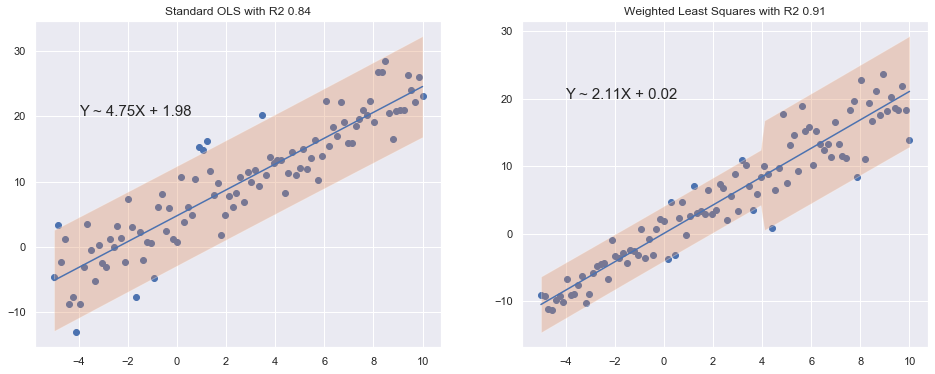

In [188]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

X = np.linspace(-5, 10, 100)
Y = 2 * X + 5 + stats.norm.rvs(scale=4, size=100)
X_with_b = sm.add_constant(X)
ols_model = sm.OLS(Y, X_with_b).fit()
_, ols_iv_l, ols_iv_u = wls_prediction_std(ols_model)

ax1.scatter(X, Y)
ax1.plot(X, ols_model.predict())
ax1.fill_between(X, ols_iv_l, ols_iv_u, alpha=0.3)
ols_text = f'Y ~ {ols_model.params[0].round(2)}X + {ols_model.params[1].round(2)}'
ax1.text(-4, 20, ols_text, fontsize=15)
ax1.set_title(f'Standard OLS with R2 {ols_model.rsquared.round(2)}');

w = np.full([100], 2)
w[60:] = 4
first_inv = 2 * X[:60]
sec_inv = 2 * X[60:]
Y_wls = np.hstack([first_inv, sec_inv])
Y_wls += stats.norm.rvs(size=100) * w
wls_model = sm.WLS(Y_wls, sm.add_constant(X), weights = 1/ (w ** 2)).fit()

ax2.scatter(X, Y_wls)
prdst, wls_iv_l, wls_iv_u = wls_prediction_std(wls_model)
ax2.fill_between(X, wls_iv_l, wls_iv_u, alpha=0.3)
ax2.plot(X, wls_model.predict())
wls_text = f'Y ~ {wls_model.params[1].round(2)}X + {wls_model.params[0].round(2)}'
ax2.text(-4, 20, wls_text, fontsize=15)
ax2.set_title(f'Weighted Least Squares with R2 {wls_model.rsquared.round(2)}');

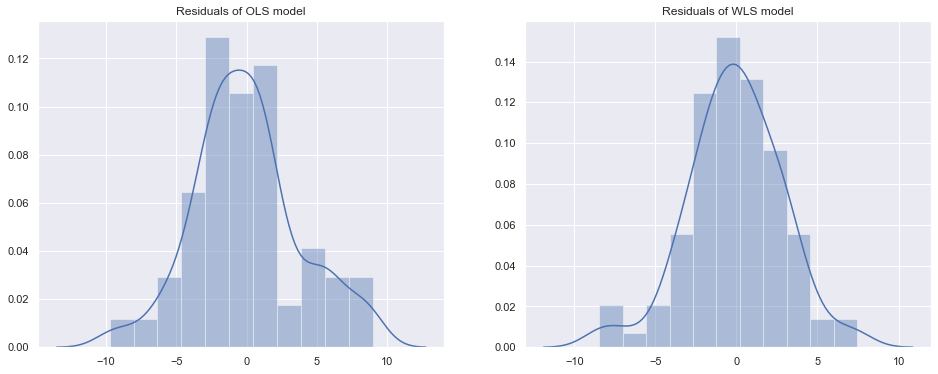

In [197]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
sns.distplot(ols_model.resid, ax=ax1)
ax1.set_title('Residuals of OLS model')
sns.distplot(wls_model.resid, ax=ax2)
ax2.set_title('Residuals of WLS model');

### Copper analysis

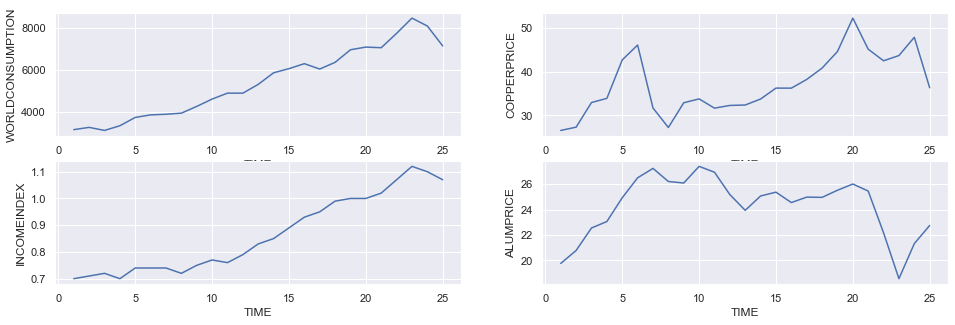

In [208]:
df = sm.datasets.copper.load_pandas().data
cols = ['WORLDCONSUMPTION', 'COPPERPRICE', 'INCOMEINDEX', 'ALUMPRICE']
_ , axes = plt.subplots(2, 2, figsize=(16,5))
for i, ax in enumerate(axes.flat):
    sns.lineplot(y=cols[i], x='TIME', data=df, ax=ax)

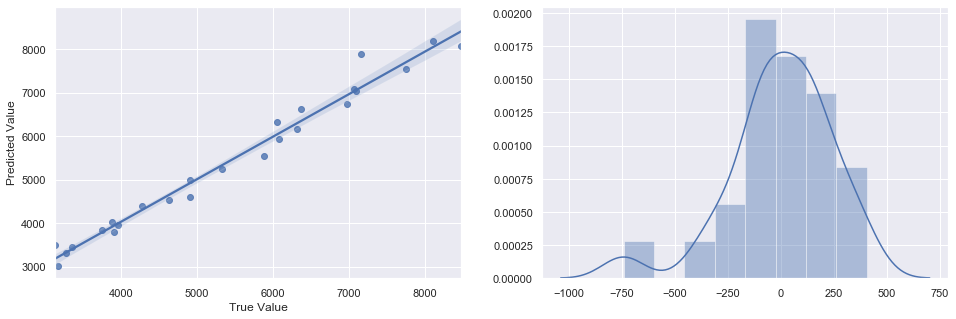

In [264]:
Y = df['WORLDCONSUMPTION']
X = df.drop(columns='WORLDCONSUMPTION')

model = sm.OLS(Y, sm.add_constant(X)).fit()
Y_pred = model.predict()
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))
sns.regplot(Y, Y_pred, ax=ax1)
ax1.set_xlabel('True Value')
ax1.set_ylabel('Predicted Value')
sns.distplot(model.resid, ax=ax2);

In [254]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       WORLDCONSUMPTION   R-squared:                       0.978
Model:                            OLS   Adj. R-squared:                  0.973
Method:                 Least Squares   F-statistic:                     171.0
Date:                Fri, 27 Nov 2020   Prob (F-statistic):           4.11e-15
Time:                        22:55:25   Log-Likelihood:                -172.61
No. Observations:                  25   AIC:                             357.2
Df Residuals:                      19   BIC:                             364.5
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const            283.9552   2768.572      0.103      0.919   -5510.733    6078.644
COPPERPRICE       15.0432     14.761      1.019      0.321     -15.852      45.938
INCOMEINDEX     1442.8858   3168.592      0.455      0.654   -5189.054    8074.826
ALUMPRICE        -64.1230     47.258     -1.357      0.191    -163.035      34.789
INVENTORYINDEX  2450.3845   1827.270      1.341      0.196   -1374.136    6274.905
TIME             187.2307     54.595      3.429      0.003      72.961     301.500
==============================================================================
Omnibus:                        8.395   Durbin-Watson:                   1.312
Prob(Omnibus):                  0.015   Jarque-Bera (JB):                6.465
Skew:                          -0.959   Prob(JB):                       0.0395
Kurtosis:                       4.589   Cond. No.                     3.36e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.36e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Generalized Linear Models

In [267]:
import os

In [276]:
fish_path = os.path.join('datasets', 'Fish.csv')
df = pd.read_csv(fish_path)
print('Data shape: ', df.shape)
print('Null Values')
print(df.isna().sum())
df.head()

Data shape:  (159, 7)
Null Values
Species    0
Weight     0
Length1    0
Length2    0
Length3    0
Height     0
Width      0
dtype: int64


,Species,Weight,Length1,Length2,Length3,Height,Width
0,Bream,242.0,23.2,25.4,30.0,11.5200,4.0200
1,Bream,290.0,24.0,26.3,31.2,12.4800,4.3056
2,Bream,340.0,23.9,26.5,31.1,12.3778,4.6961
3,Bream,363.0,26.3,29.0,33.5,12.7300,4.4555
4,Bream,430.0,26.5,29.0,34.0,12.4440,5.1340


Weight will be our target

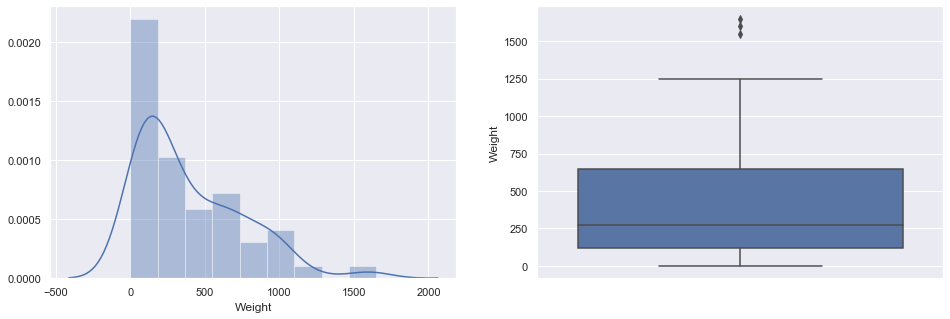

In [294]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,5))
sns.distplot(df['Weight'], ax=ax1)
sns.boxplot(y='Weight', ax=ax2, data=df)

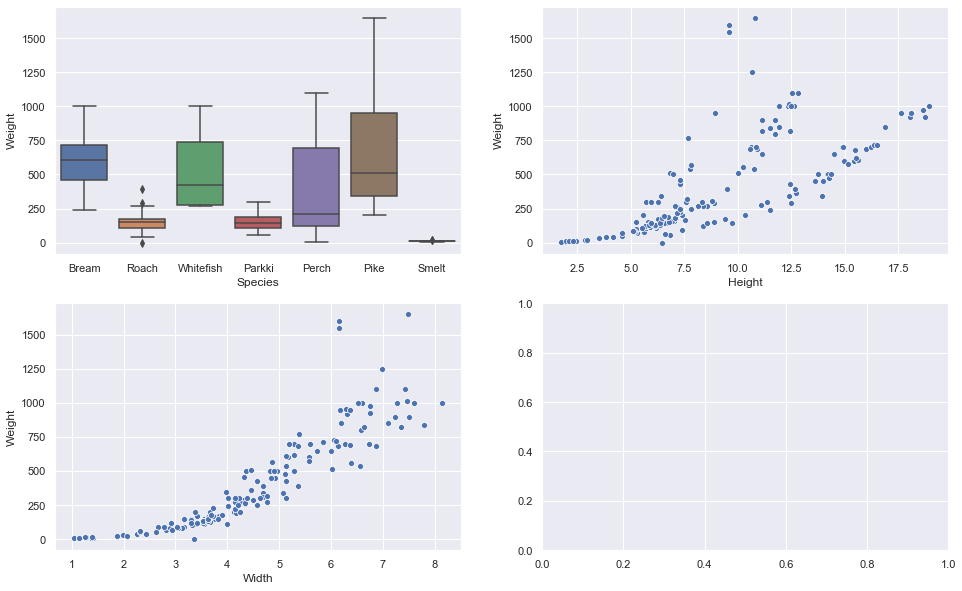

In [289]:
fig, axes = plt.subplots(2, 2, figsize=(16,10))
(ax1, ax2, ax3, ax4) = axes.flat
sns.boxplot(y='Weight', x='Species', data=df, ax=ax1)
sns.scatterplot(y='Weight', x='Height', data=df, ax=ax2)
sns.scatterplot(y='Weight', x='Width', data=df, ax=ax3)